In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu, kstest

In [68]:
data_train = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/train_set_01_processed.parquet.gzip"
)

data_test = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/test_set_01_processed.parquet.gzip"
)

In [2]:
chrome_old = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/merged_data.parquet.gzip", engine="pyarrow",
            dtype_backend="pyarrow"
)

chrome_new = pd.read_parquet('../data/processed/chrome/03_29_2023/merged_data.parquet.gzip', engine="pyarrow", dtype_backend="pyarrow")

In [5]:
chrome_train = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/train_set_featurized_BE.parquet.gzip"
)

chrome_test = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/test_set_featurized_BE.parquet.gzip"
)

In [10]:
chrome_train

,comb_col_non_tracker,comb_col_tracker,x-77-nzt_binary,x-ua-device_binary,x-amz-request-id_binary,x-cdn-cache_binary,x-aspnet-version_binary,content-security-policy-report-only_binary,x-cache_binary,x-goog-stored-content-encoding_binary,...,edge-control_binary,request-time_binary,cdn-storageserver_binary,content-encoding_binary,x-goog-generation_binary,accept-ch_binary,x-cache-hit_binary,x-server_binary,access-control-expose-headers_binary,tracker
0,2,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556443,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
556444,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
556445,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
556446,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
chrome_test.dtypes.value_counts()

uint8    163
Name: count, dtype: int64

In [ ]:
data[f"{elem}_binary"] = np.where(data[elem].isnull(), 0, 1)

In [10]:
chrome_test.iloc[:, 156:] = np.where(chrome_test.iloc[:, 156:].isnull(), 0, 1)

In [8]:
chrome_test = chrome_test.astype("uint8")

In [26]:
chrome_test['x-b3-sampled_binary'] = chrome_test['x-b3-sampled_binary'].astype("uint8")

In [29]:
def label_as_last_column(dataset: pd.DataFrame):
    temp_cols = dataset.columns.tolist()
    index_col = dataset.columns.get_loc("tracker")
    new_col_order = (
        temp_cols[0:index_col]
        + temp_cols[index_col + 1 :]
        + temp_cols[index_col : index_col + 1]
    )
    return new_col_order

In [31]:
col_order = label_as_last_column(chrome_test)

In [8]:
other_columns = chrome_train.columns.values.tolist()

In [9]:
chrome_test = chrome_test[other_columns]

In [15]:
other_columns = chrome_train.columns.values.tolist()
cols_not_in_train_chrome = list(set(other_columns).difference(chrome_test.columns.values.tolist()))
cols_not_in_test_chrome = list(set(chrome_test.columns.values.tolist()).difference(other_columns))

In [9]:
cols_not_in_train_chrome

['x-ttl_binary',
 'x-wadp-cache_binary',
 'x-ua-device_binary',
 'x-cdn-cache_binary',
 'x-cdnterra-cache-status_binary',
 'x-77-nzt_binary',
 'x-b3-sampled_binary']

In [16]:
cols_not_in_test_chrome

['network_info_binary',
 'amp-access-control-allow-source-origin_binary',
 'cdn-edgestorageid_binary',
 'x-goog-stored-content-length_binary',
 'perma-cache_binary',
 'allow_binary',
 'cdn-cache_binary',
 'x-cache-status_binary',
 'x-cdn-diag_binary',
 'x-cached_binary',
 'x-country-code_binary',
 'document-policy_binary']

In [21]:
chrome_test.drop(cols_not_in_test_chrome, axis=1, inplace=True)

In [22]:
chrome_test

,comb_col_non_tracker,comb_col_tracker,x-powered-by_binary,x-frontend_binary,age_binary,x-cache-hit_binary,x-amz-meta-codebuild-buildarn_binary,x-nginx-request-id_binary,cf-ray_binary,expect-ct_binary,...,x-li-fabric_binary,x-amz-server-side-encryption_binary,x-fb-trip-id_binary,connection_binary,request-id_binary,access-control-allow-methods_binary,x-tt-trace-tag_binary,x-goog-generation_binary,access-control-max-age_binary,tracker
0,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,3,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,1,1,...,0,0,0,1,0,1,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171739,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
171740,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
171741,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
171742,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [25]:
chrome_test = chrome_test.reindex(columns=chrome_test.columns.tolist() + cols_not_in_train_chrome)

In [24]:
chrome_test

,comb_col_non_tracker,comb_col_tracker,x-powered-by_binary,x-frontend_binary,age_binary,x-cache-hit_binary,x-amz-meta-codebuild-buildarn_binary,x-nginx-request-id_binary,cf-ray_binary,expect-ct_binary,...,x-li-fabric_binary,x-amz-server-side-encryption_binary,x-fb-trip-id_binary,connection_binary,request-id_binary,access-control-allow-methods_binary,x-tt-trace-tag_binary,x-goog-generation_binary,access-control-max-age_binary,tracker
0,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,3,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,1,1,...,0,0,0,1,0,1,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171739,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
171740,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
171741,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
171742,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [10]:
chrome_test.to_parquet("test_set_featurized_BE.parquet.gzip", compression="gzip")

In [14]:
chrome_train['x-ttl_binary']

0         0
1         0
2         0
3         0
4         0
         ..
556443    0
556444    0
556445    0
556446    0
556447    0
Name: x-ttl_binary, Length: 556448, dtype: uint8[pyarrow]

In [5]:
chrome_old[['etag']].value_counts()

etag                                         
"1660137096112928"                               1483
"ad4b0f606e0f8465bc4c4c170b37e1a3:1463757360"    1208
1484984001845508991                               983
12862140795212465669                              953
"1637097310169751"                                892
                                                 ... 
"62e018c2-1ff3"                                     1
"62e018c2-1f6"                                      1
"62e018c2-1e9"                                      1
"62e018c2-16f1"                                     1
||2417927|nl|plone default|0|0|                     1
Name: count, Length: 348615, dtype: int64

In [3]:
firefox = pd.read_parquet('../data/processed/firefox/08_12_2022/merged_data.parquet.gzip', engine="pyarrow",
            dtype_backend="pyarrow")

brave = pd.read_parquet('../data/processed/brave/08_12_2022/merged_data.parquet.gzip', engine="pyarrow",
            dtype_backend="pyarrow")

In [69]:
data = pd.concat([data_train, data_test], ignore_index=True)

<Figure size 2000x1000 with 0 Axes>

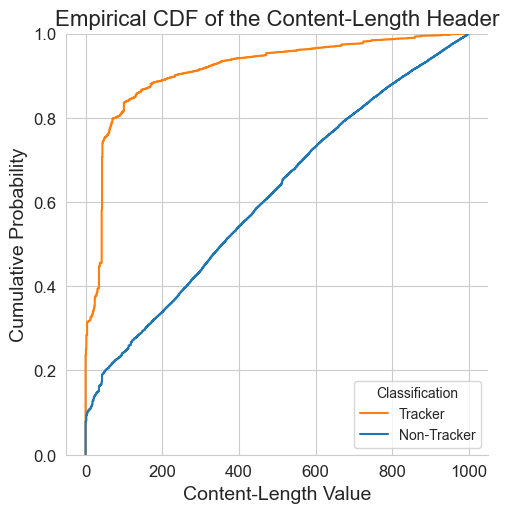

In [3]:
plt.figure(figsize=(20, 10))
cl_values = chrome_old[["content-length", "tracker"]].dropna().astype('Int32')
# sns.histplot(cl_values[cl_values['content-length'] < 1000], bins=10, x="content-length", hue='tracker', element='step')

sns.displot(cl_values[cl_values['content-length'] < 1000], x="content-length", kind='ecdf', hue='tracker',
            legend=False)

plt.title('Empirical CDF of the Content-Length Header', fontsize=16)
plt.xlabel('Content-Length Value', fontsize=14)
plt.ylabel('Cumulative Probability', fontsize=14)
plt.legend(title="Classification", labels=['Tracker', 'Non-Tracker'], fontsize=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

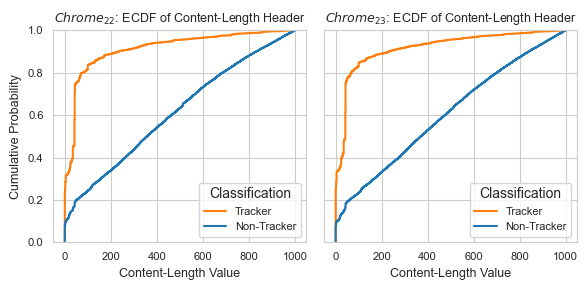

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# First dataset (chrome_old)
cl_values_chrome = chrome_old[["content-length", "tracker"]].dropna().astype('Int32')
sns.ecdfplot(data=cl_values_chrome[cl_values_chrome['content-length'] < 1000], x="content-length", hue='tracker', ax=axes[0])
axes[0].set_title('$Chrome_{22}$: ECDF of Content-Length Header', fontsize=9)
axes[0].set_xlabel('Content-Length Value', fontsize=9)
axes[0].set_ylabel('Cumulative Probability', fontsize=9)
axes[0].tick_params(labelsize=8)
axes[0].legend(title="Classification", labels=['Tracker', 'Non-Tracker'], fontsize=8)

# Second dataset (firefox_new)
cl_values_firefox = chrome_new[["content-length", "tracker"]].dropna().astype('Int32')
sns.ecdfplot(data=cl_values_firefox[cl_values_firefox['content-length'] < 1000], x="content-length", hue='tracker', ax=axes[1])
axes[1].set_title('$Chrome_{23}$: ECDF of Content-Length Header', fontsize=9)
axes[1].set_xlabel('Content-Length Value', fontsize=9)
axes[1].set_ylabel('')
axes[1].tick_params(labelsize=8, labelleft=False)
axes[1].legend(title="Classification", labels=['Tracker', 'Non-Tracker'], fontsize=8)

plt.tight_layout()

# Save the figure as a PDF
plt.savefig('content_length_comparison.pdf', format='pdf', bbox_inches='tight')
plt.show()

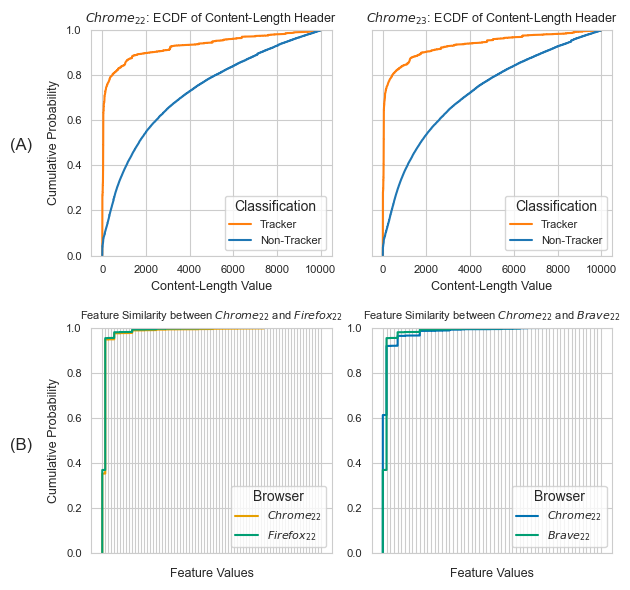

In [5]:
feature = 'x-xss-protection'

chrome_old_xss = chrome_old[feature].dropna().astype('category')
# chrome_new_xss = chrome_new[feature].dropna().astype('category')

firefox_xss = firefox[feature].dropna().astype('category')
brave_xss = brave[feature].dropna().astype('category')

df = pd.DataFrame({
    feature: np.concatenate((chrome_old_xss, firefox_xss)),
    'set': ['Chrome'] * len(chrome_old_xss) + ['Firefox'] * len(firefox_xss)
})

df2 = pd.DataFrame({
    feature: np.concatenate((chrome_old_xss, brave_xss)),
    'set': ['Chrome'] * len(chrome_old_xss) + ['Brave'] * len(brave_xss)
})

chrome_color = '#009E73'
firefox_color = '#E69F00'
brave_color = "#0072B2"

palette = {'Chrome': '#009E73', 'Firefox': '#E69F00', 'Brave': '#0072B2'}
palette2 = {'Chrome': '#009E73', 'Brave': '#0072B2'}

fig, axes = plt.subplots(2, 2, figsize=(6, 6))  # Adjust the figsize as necessary

fig.subplots_adjust(hspace=0.5)  # Adjust the vertical spacing

# Row A
fig.text(-0.02, 0.75, '(A)', ha='center', va='center', fontsize=12)
fig.text(-0.02, 0.25, '(B)', ha='center', va='center', fontsize=12)

# Plot your first two existing subplots in the first row
# First dataset (chrome_old)
cl_values_chrome = chrome_old[["content-length", "tracker"]].dropna().astype('Int32')
sns.ecdfplot(data=cl_values_chrome[cl_values_chrome['content-length'] < 10000], x="content-length", hue='tracker', ax=axes[0, 0])
axes[0, 0].set_title('$Chrome_{22}$: ECDF of Content-Length Header', fontsize=9)
axes[0, 0].set_xlabel('Content-Length Value', fontsize=9)
axes[0, 0].set_ylabel('Cumulative Probability', fontsize=9)
axes[0, 0].tick_params(labelsize=8)
axes[0, 0].legend(title="Classification", labels=['Tracker', 'Non-Tracker'], fontsize=8)

# Second dataset (firefox_new)
cl_values_firefox = chrome_new[["content-length", "tracker"]].dropna().astype('Int32')
sns.ecdfplot(data=cl_values_firefox[cl_values_firefox['content-length'] < 10000], x="content-length", hue='tracker', ax=axes[0, 1])
axes[0, 1].set_title('$Chrome_{23}$: ECDF of Content-Length Header', fontsize=9)
axes[0, 1].set_xlabel('Content-Length Value', fontsize=9)
axes[0, 1].set_ylabel('')
axes[0, 1].tick_params(labelsize=8, labelleft=False)
axes[0, 1].legend(title="Classification", labels=['Tracker', 'Non-Tracker'], fontsize=8)

# Plot the new subplot in the second row for df
sns.ecdfplot(data=df, x=feature, hue='set', log_scale=False, palette=palette, ax=axes[1, 0])
axes[1, 0].set_title('Feature Similarity between $Chrome_{22}$ and $Firefox_{22}$', fontsize=8)
axes[1, 0].set_xlabel('Feature Values', fontsize=9)  # Remove x-axis label
axes[1, 0].set_ylabel('Cumulative Probability', fontsize=9)
axes[1, 0].tick_params(labelsize=8)
# Set the custom legend with new labels and position it in the bottom right corner
handles, labels = axes[1, 0].get_legend_handles_labels()
axes[1, 0].legend(labels=['$Chrome_{22}$', '$Firefox_{22}$'], loc='lower right', fontsize=8, title="Browser")
axes[1, 0].set_xticklabels([])  # Clear x-tick labels

# Plot the new subplot in the second row for df2
sns.ecdfplot(data=df2, x=feature, hue='set', log_scale=False, palette=palette2, ax=axes[1, 1])
axes[1, 1].set_title('Feature Similarity between $Chrome_{22}$ and $Brave_{22}$', fontsize=8)
axes[1, 1].set_xlabel('Feature Values', fontsize=9)  # Remove x-axis label
axes[1, 1].set_ylabel('')
axes[1, 1].tick_params(labelsize=8)
# Set the custom legend with new labels and position it in the bottom right corner
handles, labels = axes[1, 1].get_legend_handles_labels()
axes[1, 1].legend(labels=['$Chrome_{22}$', '$Brave_{22}$'], loc='lower right', fontsize=8, title="Browser")
axes[1, 1].set_xticklabels([])  # Clear x-tick labels

# Adjust layout
# plt.tight_layout(rect=[0.05, 0.05, 1, 1]) 

# Adjust layout
plt.tight_layout()
plt.savefig('content_length_comparison.svg', format='svg', bbox_inches='tight')
plt.show()

In [75]:
cl_values_firefox.loc[cl_values_firefox['tracker'] == 1]['content-length'].median()

45.0

In [69]:
cl_values_chrome.loc[cl_values_chrome['tracker'] == 1]

,content-length,tracker
59,43,1
78,200,1
160,51,1
192,48,1
222,1366,1
...,...,...
858669,42,1
858671,42,1
858675,7,1
858707,35,1


In [99]:
def create_value_comparison(header_field, n_values):
    header_field_df = pd.DataFrame(
        brave[[f"{header_field}", "tracker"]].value_counts()
    ).reset_index()
    header_field_df.columns = [f"{header_field}", "tracker", "frequency"]
    header_field_df.sort_values(by=["frequency"], ascending=False, inplace=True)

    test_values = header_field_df[0:n_values][f"{header_field}"].values.tolist()
    frequent_content_types = (
        header_field_df[header_field_df[f"{header_field}"].isin(test_values)]
        .reset_index()
        .sort_values(by=f"{header_field}")
    )
    non_tracker = frequent_content_types[frequent_content_types.tracker == 0]
    tracker = frequent_content_types[frequent_content_types.tracker == 1]
    return non_tracker, tracker


def create_value_comparison_plot(non_tracker, tracker, n, header_field):
    r = np.arange(n)
    width = 0.25

    plt.figure(figsize=(8, 5))
    plt.bar(r, non_tracker["frequency"], log=True, label="Non-Tracker", width=width)
    plt.bar(r + width, tracker["frequency"], log=True, label="Tracker", width=width)
    plt.xticks(
        r + width / 2,
        non_tracker[f"{header_field}"].values.tolist(),
        # rotation=45,
        fontsize=12,
        fontweight="bold",
        ha="right",
    )
    # plt.title('Distribution of Content-Disposition Header Values', fontsize=16)
    # plt.xlabel('Content-Disposition Value', fontsize=14)
    # plt.ylabel('Frequency', fontsize=14)
    # plt.legend(title="Classification", labels=['Tracker', 'Non-Tracker'], fontsize=10)
    # plt.xticks(fontsize=12)
    # plt.yticks(fontsize=12)
    plt.legend()

ValueError: shape mismatch: objects cannot be broadcast to a single shape

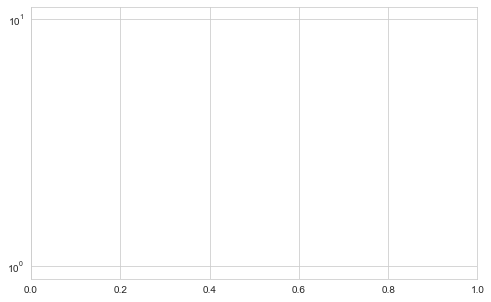

In [107]:
non_tracker_cd, tracker_cd = create_value_comparison("server", 20)
create_value_comparison_plot(non_tracker_cd, tracker_cd, len(tracker_cd), 'server')

In [105]:
data[['content-type', 'tracker']].value_count

content-type               tracker
image/jpeg                 0          38396
application/javascript     0          31775
image/png                  0          28561
image/gif                  1          21918
image/webp                 0          20127
                                      ...  
content-type: image/png    0              1
font/ttf                   1              1
font/woff; charset=utf-8   0              1
image/bmp                  1              1
application/x-javascript;  1              1
Length: 422, dtype: int64

In [44]:
clCT = data[['content-length', 'tracker', 'content-type']]

In [47]:
clCT.dropna(inplace=True)

<ipython-input-47-b6766e2255ce>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clCT.dropna(inplace=True)


In [53]:
data[['content-length', 'tracker']].value_counts()

content-type                                                               tracker
image/jpeg                                                                 0          37247
image/png                                                                  0          27654
image/gif                                                                  1          20874
image/webp                                                                 0          19733
application/javascript                                                     0          19175
                                                                                      ...  
image/webp; charset="utf-8"                                                0              1
image/vnd.microsoft.icon;charset=utf-8                                     0              1
image/vnd.microsoft.icon; charset=binary                                   0              1
application/vnd.itv.hubsvc.schedule.v3+vnd.itv.hubsvc.channel.v2+hal+json  0             

In [21]:
chrome = pd.read_parquet("../data/processed/chrome/08_12_2022/train_set_01.parquet.gzip")
chrome2 = pd.read_parquet("../data/processed/chrome/08_12_2022/test_set_01.parquet.gzip")

chromee = pd.concat([chrome, chrome2], ignore_index=True)

In [54]:
firefox = pd.read_parquet("../data/processed/firefox/08_12_2022/test_set.parquet.gzip")

In [2]:
brave = pd.read_parquet("../data/processed/brave/08_12_2022/test_set_0123.parquet.gzip")

In [3]:
brave = brave.iloc[:, 6:]

In [4]:
# TODO change var name, a bit misleading here
na_per_row = pd.DataFrame((brave.isnull().sum(axis=1) - len(brave.columns))*-1)
na_per_row["tracker"] = brave["tracker"]

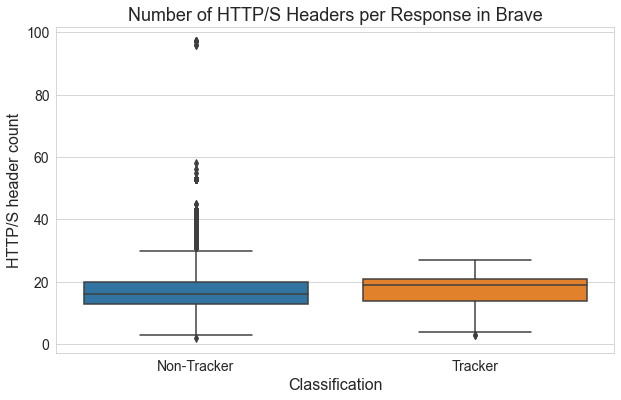

In [6]:
plt.figure(figsize=(10, 6))
g = sns.boxplot(data=na_per_row, y=na_per_row.columns.values[0], x='tracker')

plt.title('Number of HTTP/S Headers per Response in Brave', fontsize=18)
plt.xlabel('Classification', fontsize=16)
plt.ylabel('HTTP/S header count', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
g.set_xticklabels(['Non-Tracker', 'Tracker'], fontsize=14)
plt.show()

In [76]:
nt = chromee[chromee['tracker'] == 0].iloc[:, 6:]
t = chromee[chromee['tracker'] == 1].iloc[:, 6:]

In [69]:
del chrome2

In [19]:
brave.iloc[:, :40]

,date,expires,cache-control,content-type,strict-transport-security,accept-ch,bfcache-opt-in,p3p,content-encoding,server,...,x-ig-origin-region,x-fb-trip-id,x-fb-rlafr,document-policy,content-security-policy-report-only,x-fb-debug,expiry,x-powered-by,last-modified,cross-origin-embedder-policy
0,"fri, 12 aug 2022 09:19:05 gmt",-1,"private, max-age=0",text/html; charset=utf-8,max-age=31536000,sec-ch-ua-platform,unload,"cp=""this is not a p3p policy! see g.co/p3phelp...",br,gws,...,None,None,None,None,None,None,None,None,None,None
1,"fri, 12 aug 2022 09:19:05 gmt","mon, 01 jan 1990 00:00:00 gmt","no-cache, no-store, max-age=0, must-revalidate",text/html; charset=utf-8,max-age=31536000,"sec-ch-ua-arch, sec-ch-ua-bitness, sec-ch-ua-f...",None,"cp=""this is not a p3p policy! see http://suppo...",br,esf,...,None,None,None,None,None,None,None,None,None,None
2,"fri, 12 aug 2022 09:19:05 gmt","sat, 01 jan 2000 00:00:00 gmt","private, no-cache, no-store, must-revalidate",text/html; charset=utf-8,max-age=31536000,None,None,None,gzip,None,...,cln,1679558926,None,None,None,None,None,None,None,None
3,"fri, 12 aug 2022 09:19:05 gmt","sat, 01 jan 2000 00:00:00 gmt","private, no-cache, no-store, must-revalidate","text/html; charset=""utf-8""",max-age=15552000; preload,None,None,None,br,None,...,None,None,0,force-load-at-top,default-src data: blob: 'self' https://*.fbsbx...,r684lntiqpkzx7nriyd3ykryjeebureppjpbmg5pnaz+iy...,None,None,None,None
4,"fri, 12 aug 2022 09:19:05 gmt",None,"no-cache, no-store, must-revalidate, pre-check...",text/html; charset=utf-8,max-age=631138519,None,None,None,gzip,tsa_f,...,None,None,None,None,None,None,"tue, 31 mar 1981 05:00:00 gmt",express,"fri, 12 aug 2022 09:19:05 gmt",unsafe-none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564658,"fri, 12 aug 2022 21:59:48 gmt",None,None,application/octet-stream,max-age=31536000; includesubdomains; preload,None,None,None,None,nginx,...,None,None,None,None,default-src 'self'; frame-src https://cdn.ruta...,None,None,None,None,None
564659,"fri, 12 aug 2022 21:59:48 gmt","sun, 14 aug 2022 21:59:48 gmt",max-age=172800,application/javascript,max-age=31536000; includesubdomains; preload,None,None,None,gzip,nginx,...,None,None,None,None,default-src 'self'; frame-src https://cdn.ruta...,None,None,None,"fri, 12 aug 2022 10:08:03 gmt",None
564660,"fri, 12 aug 2022 21:59:48 gmt","sun, 14 aug 2022 21:59:48 gmt",max-age=172800,application/javascript,max-age=31536000; includesubdomains; preload,None,None,None,gzip,nginx,...,None,None,None,None,default-src 'self'; frame-src https://cdn.ruta...,None,None,None,"fri, 12 aug 2022 10:08:03 gmt",None
564661,"fri, 12 aug 2022 21:59:48 gmt","sun, 14 aug 2022 21:59:48 gmt",max-age=172800,application/javascript,max-age=31536000; includesubdomains; preload,None,None,None,gzip,nginx,...,None,None,None,None,default-src 'self'; frame-src https://cdn.ruta...,None,None,None,"fri, 12 aug 2022 10:08:03 gmt",None


In [57]:
prevalent_header_chrome = chromee.iloc[:, 6:46]

In [58]:
prevalent_header_chrome['tracker'] = chromee[['tracker']]

In [59]:
nt_length = len(prevalent_header_chrome[prevalent_header_chrome["tracker"] == 0])
t_length = len(prevalent_header_chrome[prevalent_header_chrome["tracker"] ==1])

prevalent_header_chrome.groupby('tracker').agg(lambda x: f'{((x.notnull().sum())/ nt_length)*100} --'
                                                         f'{((x.notnull().sum())/ t_length)*100}')

,pragma,content-type,last-modified,accept-ranges,etag,p3p,x-xss-protection,x-content-type-options,strict-transport-security,x-robots-tag,...,x-goog-hash,x-goog-storage-class,cf-cache-status,expect-ct,report-to,nel,cf-ray,alt-svc,access-control-allow-credentials,access-control-allow-origin
tracker,,,,,,,,,,,,,,,,,,,,,
0,4.550945939282369 --11.458990781073783,98.52972599812621 --248.09154776562613,79.34178734035734 --199.77754555142837,59.77991091240816 --150.52199195025298,66.67598086753563 --167.8858550010864,2.6656421045710808 --6.711916315740463,18.795098538766254 --47.324855921944355,29.85091799667976 --75.16270214901344,34.78525288055359 --87.58704176970274,1.5245155245812718 --3.8386325776779895,...,1.353572543927415 --3.4082090864882204,1.3511070201679842 --3.4020010553652913,17.13374644553658 --43.14167761694379,18.53704038527918 --46.675081997744414,9.803744308749323 --24.68520108847479,5.668650043557586 --14.273298223468428,17.889429477802068 --45.04443915612163,16.983760416837885 --42.76402239029892,8.783017472345042 --22.115076203582035,48.03990861125265 --120.961417086571
1,13.283831095185656 --33.44783701848959,36.06116142605894 --90.79969787581868,14.272095202090766 --35.93622282693044,7.7577705090484725 --19.53356992829724,9.319268890021204 --23.46532297281917,10.878712667861077 --27.39190265807199,13.306842650273673 --33.50577864230359,14.512072848008678 --36.540471189562226,10.38807343973438 --26.15650446460905,0.5629612584033268 --1.417500439735538,...,0.25600355035421357 --0.6446005649308322,0.25600355035421357 --0.6446005649308322,2.4934663620375086 --6.278388808989228,2.817271815776065 --7.093710229800619,3.3103765676621904 --8.335316454386492,1.087295977908907 --2.737741725211849,2.7839872450237513 --7.009901809641073,17.735334242837652 --44.65643721093855,11.34798402340604 --28.573497915136215,19.744736106773615 --49.71598257612598


In [47]:
prevalent_header_brave = brave.iloc[:, :40]
prevalent_header_brave['tracker'] = brave[['tracker']]

In [50]:
nt_lengthb = len(prevalent_header_brave[prevalent_header_brave["tracker"] == 0])
t_lengthb = len(prevalent_header_brave[prevalent_header_brave["tracker"] ==1])

prevalent_header_brave.groupby('tracker').agg(lambda x: f'{((x.notnull().sum())/ nt_lengthb)*100} --'
                                                         f'{((x.notnull().sum())/ t_lengthb)*100}')

,date,expires,cache-control,content-type,strict-transport-security,accept-ch,bfcache-opt-in,p3p,content-encoding,server,...,x-ig-origin-region,x-fb-trip-id,x-fb-rlafr,document-policy,content-security-policy-report-only,x-fb-debug,expiry,x-powered-by,last-modified,cross-origin-embedder-policy
tracker,,,,,,,,,,,,,,,,,,,,,
0,99.69650473132214 --19481.147826086955,51.78163292914765 --10118.365217391305,85.58619977642812 --16723.930434782607,98.88979472683646 --19323.513043478262,33.76967824161427 --6598.747826086957,0.5583956937492435 --109.11304347826088,0.07565131330679901 --14.782608695652174,2.584248862560254 --504.97391304347826,46.50384130668508 --9087.060869565217,85.8480423220147 --16775.095652173914,...,0.0010680185408018684 --0.20869565217391303,0.1381303979437083 --26.99130434782609,0.32022755915042683 --62.57391304347826,0.31079339537334366 --60.7304347826087,3.442935769364956 --672.7652173913043,0.3414099268763306 --66.71304347826087,0.0008900154506682236 --0.17391304347826086,4.66457097695216 --911.4782608695652,81.50191887331164 --15925.843478260871,0.26842865992153625 --52.452173913043474
1,0.5053507728894174 --98.74782608695652,0.3129294324549474 --61.14782608695653,0.3789685788945296 --74.05217391304348,0.5032147358078136 --98.3304347826087,0.3300177291077773 --64.48695652173913,0.005518095794142986 --1.0782608695652174,0.0 --0.0,0.013706237940290644 --2.6782608695652175,0.35298012773501747 --68.97391304347826,0.17337500979016995 --33.87826086956522,...,0.0 --0.0,0.10395380463804851 --20.31304347826087,0.24457624584362783 --47.791304347826085,0.24457624584362783 --47.791304347826085,0.0028480494421383156 --0.5565217391304348,0.24457624584362783 --47.791304347826085,0.0 --0.0,0.0065861143349448545 --1.2869565217391303,0.11231994987432982 --21.94782608695652,0.0 --0.0


In [55]:
prevalent_header_firefox = firefox.iloc[:, 6:40]
prevalent_header_firefox['tracker'] = firefox[['tracker']]
nt_lengthf = len(prevalent_header_firefox[prevalent_header_firefox["tracker"] == 0])
t_lengthf = len(prevalent_header_firefox[prevalent_header_firefox["tracker"] == 1])

prevalent_header_firefox.groupby('tracker').agg(lambda x: f'{((x.notnull().sum()) / nt_lengthf) * 100} --'
                                                        f'{((x.notnull().sum()) / t_lengthf) * 100}')

,date,content-type,content-length,cache-control,cf-bgj,cf-polished,content-disposition,etag,expires,last-modified,...,alt-svc,x-firefox-http3,content-encoding,content-md5,x-ms-request-id,x-ms-version,x-ms-lease-status,x-ms-blob-type,access-control-expose-headers,access-control-allow-origin
tracker,,,,,,,,,,,,,,,,,,,,,
0,99.48513278673288 --246.4433978719693,98.00305878442893 --242.7720216291645,75.05795072709502 --185.93267050409906,84.41822539805037 --209.11983254840396,4.742524144962723 --11.748124890982034,3.441554966581513 --8.52537938252224,4.12569745073132 --10.220129077271935,67.33719577628625 --166.80690737833595,50.479519382159346 --125.04727019012734,79.37348433851675 --196.62305948020233,...,17.430846404520015 --43.17948717948718,8.155913509067917 --20.203732775161345,48.29302366192264 --119.63090877376592,4.1651292941981675 --10.317809174952032,2.0183470734530746 --4.999825571254143,1.7288046799965076 --4.2825745682888545,1.7000757654706613 --4.211407639979068,1.6997941094458981 --4.210709924995639,9.620524837836545 --23.831850688993548,47.42326985745389 --117.47636490493633
1,39.942767495768116 --98.94575266003838,36.90933210906848 --91.43136228850514,32.20426821539926 --79.77603349031921,31.852761496494793 --78.90528519099948,0.22616978788484776 --0.5602651316937032,0.2002574336066336 --0.4960753532182104,2.435197990102607 --6.032443746729461,10.022447985173628 --24.827489970347113,23.442794253090472 --58.07221350078493,15.331664051959903 --37.979417407988834,...,19.03628574567024 --47.156462585034014,6.877758468692524 --17.037502180359322,19.68775613094752 --48.77027734170591,0.11942215449959581 --0.29583115297401014,0.072667254388905 --0.18001046572475143,0.07238559836414181 --0.17931275074132216,0.06590750979458826 --0.163265306122449,0.06590750979458826 --0.163265306122449,1.7685181794881184 --4.380952380952381,19.550871302912608 --48.43118785975929


In [65]:
firefox[['tracker', 'content-encoding']].value_counts()

tracker  content-encoding
0        gzip                120801
1        gzip                 52901
0        br                   50543
1        br                   16932
0        deflate                 34
         identity                34
1        deflate                 32
         none                    31
0                                18
         utf-8                   11
         base64                   9
         utf8                     5
1        utf-8                    3
0        none                     3
         text                     2
         application/json         1
1        identity                 1
dtype: int64

In [108]:
data_train = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/train_set_01_featurized.parquet.gzip"
)


In [110]:
data_train['content-type'].value_counts()

image/jpeg                                                                34160
application/javascript                                                    31358
image/gif                                                                 27280
image/png                                                                 24171
application/javascript; charset=utf-8                                     17084
                                                                          ...  
application/vnd.rbgemc+json; charset=utf-8                                    1
application/vnd.seznam-cz.spl+json                                            1
text/html; charset=iso-8859-15                                                1
image/jpeg; name=resize_7910cde8-8a03-4eb2-acfa-dff187bbe56c335079.jpg        1
image/jpeg; name=ecu.jpg                                                      1
Name: content-type, Length: 323, dtype: int64